In [108]:
import pystac_client
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress

# 1. Annual SDS Hindcast

In [109]:
# opening STAC catalog

catalog = pystac_client.Client.open(
    #"https://storage.googleapis.com/dgds-data-public/coclico/coclico-stac/catalog.json" # cloud API
    r"p:\1000545-054-globalbeaches\15_GlobalCoastalAtlas\coclicodata\current\catalog.json" # P drive API 
)
#catalog

In [110]:
#list(catalog.get_children())

In [111]:
href = catalog.get_child("shore_mon").assets["data"].href

In [112]:
ds = xr.open_zarr(href)

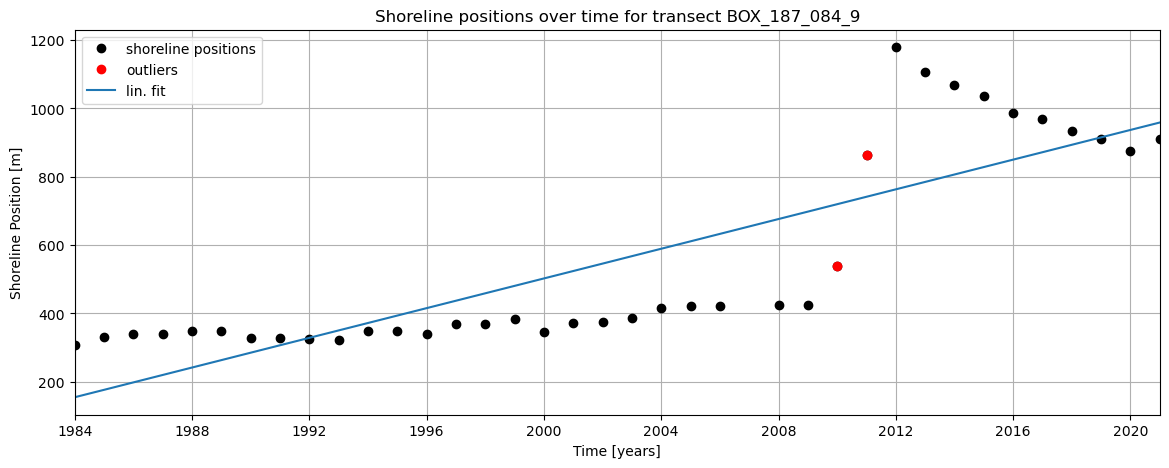

In [113]:
station = list(ds['transect_id'].values).index(b'BOX_187_084_9') # select station
# TODO: color the outlier
# TODO: add more info to the plot (sandy, uncertainty etc)

time_inds = np.array([i for i in range(len(ds.time.values))])
cr = ds.isel(stations=station)["changerate"].values
cr_unc = ds.isel(stations=station)["intercept"].values

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(ds.time, ds.isel(stations=station)["sp"].values, 'ko', label="shoreline positions")
outl_idx = [i for i,x in enumerate(ds.isel(stations= station)['outliers'].values) if x == 1]
outliers, outliers_time = ds.isel(stations=station)["sp"].values[outl_idx], ds.time[outl_idx]
ax.plot(outliers_time, outliers, 'ro', label="outliers")
ax.plot(ds.time, time_inds*cr + cr_unc, label="lin. fit")
ax.set_xlabel("Time [years]")
ax.set_ylabel("Shoreline Position [m]")
ax.set_title(
    "Shoreline positions over time for transect %s"%ds.isel(stations=station)["transect_id"].values.tolist().decode("utf-8") 
)
plt.grid()
plt.xlim(ds.time[0], ds.time[-1])
plt.legend();

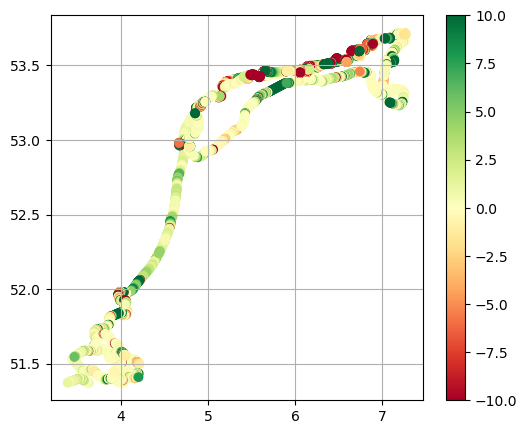

In [114]:
# trial: spatial slicing
# re-work dataset to filter on coords

min_lon = 3.369
min_lat = 51.372
max_lon = 7.275
max_lat = 53.727

# filtering on bbox values, note, slice does not work with lon & lat these are not gridded locations
bbox_bool = (ds.lon.values > min_lon) & (ds.lon.values < max_lon) & (ds.lat.values > min_lat) & (ds.lat.values < max_lat)
bbox_idx = list(compress(range(len(bbox_bool)), bbox_bool))
dsn = ds.isel(stations=bbox_idx)

# make figure
fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(dsn.lon, dsn.lat, c=dsn.changerate, vmin=-10, vmax=10, cmap='RdYlGn')
plt.colorbar(sc)

plt.grid()